# Введение в искусственные нейронные сети
# Урок 4. Сверточные нейронные сети (CNN)

## Домашнее задание

1. обучить рукописную сверточную нейронную сеть (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) на датасете cifar-10
2. оценить рост точности при увеличении ширины сети (больше фильтров)
3. оценить рост точности при увеличении глубины сети (больше слоев)
4. *сравнить с точностью полносвязной сети для этой выборки


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers
import os
from sklearn.metrics import classification_report

In [9]:
classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [10]:
# разделение тренировочной и тестовой выборки
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'тренировочные примеры')
print(X_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

X_train = X_train / 255.0
X_test = X_test / 255.0

X_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


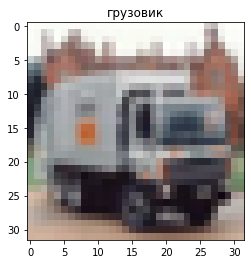

In [11]:
N = 11

plt.imshow(X_test[N])
plt.title(classes[np.argmax(y_test[N,:])])
plt.show()

In [12]:
results = pd.DataFrame(columns=['Sample', 'Train', 'Test', 'Test loss', 'Test accuracy']) # сводная таблица результатов

batch_size = 512
epochs = 10

step = [] # шаг
desc = [] # описание

train_acc = [] # результат на трейне
test_acc = [] # результат на тесте

### 1. Обучить рукописную сверточную нейронную сеть (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) на датасете cifar-10

In [13]:
from tensorflow.keras.losses import categorical_crossentropy

# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(16, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

# компиляция модели
model.compile(loss=categorical_crossentropy,
              optimizer='SGD',
              metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 2, 128)        

In [14]:
model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              shuffle=True)

Epoch 1/10
98/98 [==============================] - 16s 158ms/step - loss: 2.3037 - accuracy: 0.0990 - val_loss: 2.2972 - val_accuracy: 0.1242
Epoch 2/10
98/98 [==============================] - 15s 154ms/step - loss: 2.2965 - accuracy: 0.1218 - val_loss: 2.2919 - val_accuracy: 0.1602
Epoch 3/10
98/98 [==============================] - 15s 150ms/step - loss: 2.2909 - accuracy: 0.1419 - val_loss: 2.2849 - val_accuracy: 0.1966
Epoch 4/10
98/98 [==============================] - 15s 150ms/step - loss: 2.2842 - accuracy: 0.1535 - val_loss: 2.2755 - val_accuracy: 0.2099
Epoch 5/10
98/98 [==============================] - 15s 156ms/step - loss: 2.2738 - accuracy: 0.1644 - val_loss: 2.2610 - val_accuracy: 0.2201
Epoch 6/10
98/98 [==============================] - 15s 152ms/step - loss: 2.2604 - accuracy: 0.1734 - val_loss: 2.2373 - val_accuracy: 0.2215
Epoch 7/10
98/98 [==============================] - 15s 150ms/step - loss: 2.2379 - accuracy: 0.1824 - val_loss: 2.2041 - val_accuracy: 0.2540

In [15]:
# проверка работы обученной модели
train_loss, train_m = model.evaluate(X_train, y_train, verbose=1)
test_loss, test_m = model.evaluate(X_test, y_test, verbose=1)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

step.append(1)
desc.append('Baseline')
train_acc.append(round(train_m,2))
test_acc.append(round(test_m,2))

313/313 [==============================] - 1s 5ms/step - loss: 2.0628 - accuracy: 0.2809
train_loss: 2.0646955966949463, train_accuracy: 0.2793799936771393
test_loss: 2.0628440380096436, test_accuracy: 0.2809000015258789


313/313 [==============================] - 1s 5ms/step - loss: 2.0628 - accuracy: 0.2809
Test loss: 2.0628440380096436
Test accuracy: 0.2809000015258789


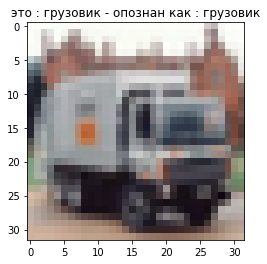

In [16]:
N = 11
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

y_p = model.predict(X_test[N:N+1])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(X_test[N])
plt.title(f'это : {classes[y_t[0]]} - опознан как : {classes[y_i[0]]}')
plt.show()

new_row = {'Sample':'CNN Baseline', 'Train':classes[y_t[0]], 'Test': classes[y_i[0]], \
           'Test loss':round(scores[0], 4), 'Test accuracy':round(scores[1], 4)}

results = results.append(new_row, ignore_index=True)

In [17]:
results

,Sample,Train,Test,Test loss,Test accuracy
0,CNN Baseline,грузовик,грузовик,2.0628,0.2809


### 2. Оценить рост точности при увеличении ширины сети (больше фильтров)

In [18]:
# конфигурирование слоев нейросети
model2 = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model2.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# полносвязные слои нейронной сети
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dense(10, activation='softmax'))

model2.summary()
# компиляция модели
model2.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 128)       36992     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 128)       147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)             

In [19]:
model2.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              shuffle=True)

Epoch 1/10
98/98 [==============================] - 87s 883ms/step - loss: 2.2917 - accuracy: 0.1338 - val_loss: 2.2654 - val_accuracy: 0.1683
Epoch 2/10
98/98 [==============================] - 83s 847ms/step - loss: 2.2456 - accuracy: 0.1915 - val_loss: 2.1499 - val_accuracy: 0.2279
Epoch 3/10
98/98 [==============================] - 87s 889ms/step - loss: 2.1178 - accuracy: 0.2473 - val_loss: 2.0167 - val_accuracy: 0.2795
Epoch 4/10
98/98 [==============================] - 88s 899ms/step - loss: 2.0511 - accuracy: 0.2656 - val_loss: 1.9589 - val_accuracy: 0.3111
Epoch 5/10
98/98 [==============================] - 85s 863ms/step - loss: 1.9775 - accuracy: 0.2970 - val_loss: 1.8899 - val_accuracy: 0.3286
Epoch 6/10
98/98 [==============================] - 89s 904ms/step - loss: 1.9106 - accuracy: 0.3256 - val_loss: 1.9886 - val_accuracy: 0.2992
Epoch 7/10
98/98 [==============================] - 91s 927ms/step - loss: 1.8793 - accuracy: 0.3367 - val_loss: 1.8019 - val_accuracy: 0.3625

In [20]:
# проверка работы обученной модели
train_loss, train_m = model2.evaluate(X_train, y_train, verbose=1)
test_loss, test_m = model2.evaluate(X_test, y_test, verbose=1)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

step.append(1)
desc.append('More filters')
train_acc.append(round(train_m,2))
test_acc.append(round(test_m,2))

313/313 [==============================] - 6s 19ms/step - loss: 1.7196 - accuracy: 0.3907
train_loss: 1.715128779411316, train_accuracy: 0.390500009059906
test_loss: 1.7196314334869385, test_accuracy: 0.39070001244544983


313/313 [==============================] - 6s 19ms/step - loss: 1.7196 - accuracy: 0.3907
Test loss: 1.7196314334869385
Test accuracy: 0.39070001244544983


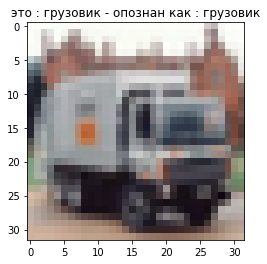

In [21]:
N = 11
scores = model2.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

y_p = model.predict(X_test[N:N+1])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(X_test[N])
plt.title(f'это : {classes[y_t[0]]} - опознан как : {classes[y_i[0]]}')
plt.show()

new_row = {'Sample':'CNN with more filters', 'Train':classes[y_t[0]], 'Test': classes[y_i[0]], \
           'Test loss':round(scores[0], 4), 'Test accuracy':round(scores[1], 4)}

results = results.append(new_row, ignore_index=True)

In [22]:
results

,Sample,Train,Test,Test loss,Test accuracy
0,CNN Baseline,грузовик,грузовик,2.0628,0.2809
1,CNN with more filters,грузовик,грузовик,1.7196,0.3907


### 3. Оценить рост точности при увеличении глубины сети (больше слоев)

In [23]:
# конфигурирование слоев нейросети
model3 = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model3.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model3.add(Activation('relu'))
model3.add(Conv2D(32, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(64, (3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(64, (3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))


# полносвязные слои нейронной сети
model3.add(Flatten())
model3.add(Dense(512))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(10))
model3.add(Activation('softmax'))

model3.summary()
# компиляция модели
model3.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_11 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 64)       

In [24]:
history_3 = model3.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test))    

Epoch 1/10
98/98 [==============================] - 59s 588ms/step - loss: 2.3079 - accuracy: 0.0971 - val_loss: 2.3022 - val_accuracy: 0.1145
Epoch 2/10
98/98 [==============================] - 61s 622ms/step - loss: 2.3038 - accuracy: 0.0990 - val_loss: 2.3014 - val_accuracy: 0.1153
Epoch 3/10
98/98 [==============================] - 61s 623ms/step - loss: 2.3021 - accuracy: 0.1044 - val_loss: 2.3005 - val_accuracy: 0.1370
Epoch 4/10
98/98 [==============================] - 60s 612ms/step - loss: 2.3002 - accuracy: 0.1106 - val_loss: 2.2991 - val_accuracy: 0.1563
Epoch 5/10
98/98 [==============================] - 58s 594ms/step - loss: 2.2984 - accuracy: 0.1137 - val_loss: 2.2966 - val_accuracy: 0.1598
Epoch 6/10
98/98 [==============================] - 60s 606ms/step - loss: 2.2952 - accuracy: 0.1170 - val_loss: 2.2919 - val_accuracy: 0.1721
Epoch 7/10
98/98 [==============================] - 61s 618ms/step - loss: 2.2891 - accuracy: 0.1257 - val_loss: 2.2808 - val_accuracy: 0.1789

In [25]:
# проверка работы обученной модели
train_loss, train_m = model3.evaluate(X_train, y_train, verbose=1)
test_loss, test_m = model3.evaluate(X_test, y_test, verbose=1)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

step.append(1)
desc.append('More layers')
train_acc.append(round(train_m,2))
test_acc.append(round(test_m,2))


313/313 [==============================] - 4s 12ms/step - loss: 2.1718 - accuracy: 0.2085
train_loss: 2.173809766769409, train_accuracy: 0.2036599963903427
test_loss: 2.1718368530273438, test_accuracy: 0.2084999978542328


313/313 [==============================] - 5s 14ms/step - loss: 2.1718 - accuracy: 0.2085
Test loss: 2.1718368530273438
Test accuracy: 0.2084999978542328


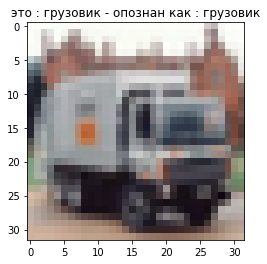

In [26]:
N = 11
scores = model3.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

y_p = model.predict(X_test[N:N+1])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(X_test[N])
plt.title(f'это : {classes[y_t[0]]} - опознан как : {classes[y_i[0]]}')
plt.show()

new_row = {'Sample':'CNN with more layers', 'Train':classes[y_t[0]], 'Test': classes[y_i[0]], \
           'Test loss':round(scores[0], 4), 'Test accuracy':round(scores[1], 4)}

results = results.append(new_row, ignore_index=True)

In [27]:
results

,Sample,Train,Test,Test loss,Test accuracy
0,CNN Baseline,грузовик,грузовик,2.0628,0.2809
1,CNN with more filters,грузовик,грузовик,1.7196,0.3907
2,CNN with more layers,грузовик,грузовик,2.1718,0.2085


### 4.\* Сравнить с точностью полносвязной сети для этой выборки.

In [28]:
# конфигурирование слоев нейросети
model4 = Sequential()

# полносвязные слои нейронной сети
model4.add(Flatten(input_shape=X_train.shape[1:]))
model4.add(Dense(512))
model4.add(Activation('relu'))
model4.add(Dropout(0.5))
model4.add(Dense(10))
model4.add(Activation('softmax'))

model4.summary()
# компиляция модели
model4.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               1573376   
_________________________________________________________________
activation_18 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                5130      
_________________________________________________________________
activation_19 (Activation)   (None, 10)                0         
Total params: 1,578,506
Trainable params: 1,578,506
Non-trainable params: 0
____________________________________________

In [29]:
history_4 = model4.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test))

Epoch 1/10
98/98 [==============================] - 3s 23ms/step - loss: 2.3055 - accuracy: 0.1616 - val_loss: 2.0218 - val_accuracy: 0.3005
Epoch 2/10
98/98 [==============================] - 2s 21ms/step - loss: 2.0443 - accuracy: 0.2657 - val_loss: 1.9436 - val_accuracy: 0.3289
Epoch 3/10
98/98 [==============================] - 3s 27ms/step - loss: 1.9755 - accuracy: 0.2974 - val_loss: 1.8960 - val_accuracy: 0.3495
Epoch 4/10
98/98 [==============================] - 2s 21ms/step - loss: 1.9318 - accuracy: 0.3124 - val_loss: 1.8607 - val_accuracy: 0.3646
Epoch 5/10
98/98 [==============================] - 2s 21ms/step - loss: 1.9093 - accuracy: 0.3279 - val_loss: 1.8382 - val_accuracy: 0.3642
Epoch 6/10
98/98 [==============================] - 3s 27ms/step - loss: 1.8779 - accuracy: 0.3345 - val_loss: 1.8160 - val_accuracy: 0.3750
Epoch 7/10
98/98 [==============================] - 2s 21ms/step - loss: 1.8563 - accuracy: 0.3456 - val_loss: 1.7987 - val_accuracy: 0.3791
Epoch 8/10
98

In [30]:
# проверка работы обученной модели
train_loss, train_m = model4.evaluate(X_train, y_train, verbose=2)
test_loss, test_m = model4.evaluate(X_test, y_test, verbose=2)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

step.append(1)
desc.append('Fully connected networks')
train_acc.append(round(train_m,2))
test_acc.append(round(test_m,2))


1563/1563 - 2s - loss: 1.7513 - accuracy: 0.4011
313/313 - 0s - loss: 1.7566 - accuracy: 0.4015
train_loss: 1.751306414604187, train_accuracy: 0.40105998516082764
test_loss: 1.7566466331481934, test_accuracy: 0.40149998664855957


313/313 [==============================] - 1s 2ms/step - loss: 1.7566 - accuracy: 0.4015
Test loss: 1.7566466331481934
Test accuracy: 0.40149998664855957


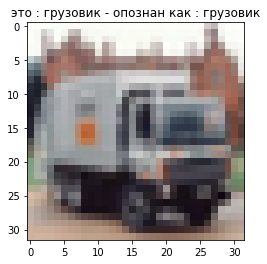

In [31]:
N = 11
scores = model4.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

y_p = model.predict(X_test[N:N+1])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(X_test[N])
plt.title(f'это : {classes[y_t[0]]} - опознан как : {classes[y_i[0]]}')
plt.show()

new_row = {'Sample':'CNN with fully connected networks', 'Train':classes[y_t[0]], 'Test': classes[y_i[0]], \
           'Test loss':round(scores[0], 4), 'Test accuracy':round(scores[1], 4)}

results = results.append(new_row, ignore_index=True)

In [32]:
results

,Sample,Train,Test,Test loss,Test accuracy
0,CNN Baseline,грузовик,грузовик,2.0628,0.2809
1,CNN with more filters,грузовик,грузовик,1.7196,0.3907
2,CNN with more layers,грузовик,грузовик,2.1718,0.2085
3,CNN with fully connected networks,грузовик,грузовик,1.7566,0.4015


## Выводы:

**Использование модели с увеличением фильтров увеличил тестовую точность. Использование модели с большим количеством слоёв снизил тестовую точность, а использование полносвязной сети показал максимальную тестовую точность.**